**Problem statement:- Forecast the Airlines Passengers data set. Prepare a document for the model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.**

In [1]:
!pip install pmdarima

## 1. Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.arima_model import ARMA
import warnings
warnings.filterwarnings('ignore')

## 2. Importing data

In [3]:
temp_data = pd.read_excel('Airlines+Data.xlsx')
temp_data

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


## 3. Initial Data Analysis

In [4]:
temp_data.shape

(96, 2)

In [5]:
temp_data.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [6]:
temp_data.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

## 4. Data Cleaning

In [7]:
airlines_data = temp_data.dropna()

In [8]:
airlines_data.index = pd.to_datetime(airlines_data.Month)

In [9]:
airlines_data = airlines_data["Passengers"]['1995-01-01	':'2002-12-01']

In [10]:
airlines_data.describe()

count     96.000000
mean     213.708333
std       71.918216
min      104.000000
25%      156.000000
50%      200.000000
75%      264.750000
max      413.000000
Name: Passengers, dtype: float64

In [11]:
airlines_data.dtypes

dtype('int64')

**Data Understanding by Data Visualization**

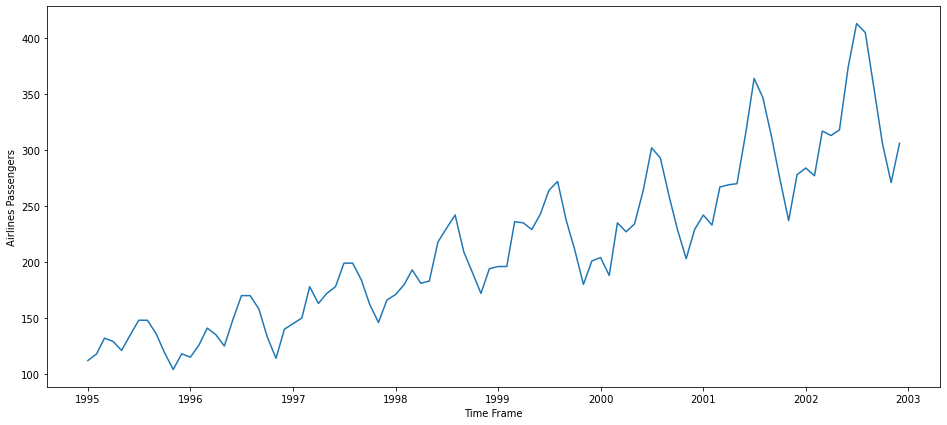

In [12]:
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Time Frame')
ax1.set_ylabel('Airlines Passengers')
ax1.plot(airlines_data)

## 5. Checking Stationarity
#### Method 1 - Rolling Statistics

***a) Determining Rolling statistics***

In [13]:
rolLmean = airlines_data.rolling(10).mean() 
rolLmean

Month
1995-01-01      NaN
1995-02-01      NaN
1995-03-01      NaN
1995-04-01      NaN
1995-05-01      NaN
              ...  
2002-08-01    321.6
2002-09-01    333.4
2002-10-01    336.2
2002-11-01    334.9
2002-12-01    337.8
Name: Passengers, Length: 96, dtype: float64

In [14]:
rolLstd = airlines_data.rolling(10).std()
rolLstd

Month
1995-01-01          NaN
1995-02-01          NaN
1995-03-01          NaN
1995-04-01          NaN
1995-05-01          NaN
                ...    
2002-08-01    58.332762
2002-09-01    50.761315
2002-10-01    48.066620
2002-11-01    49.780518
2002-12-01    46.787463
Name: Passengers, Length: 96, dtype: float64

***b) Plot Rolling statistics***

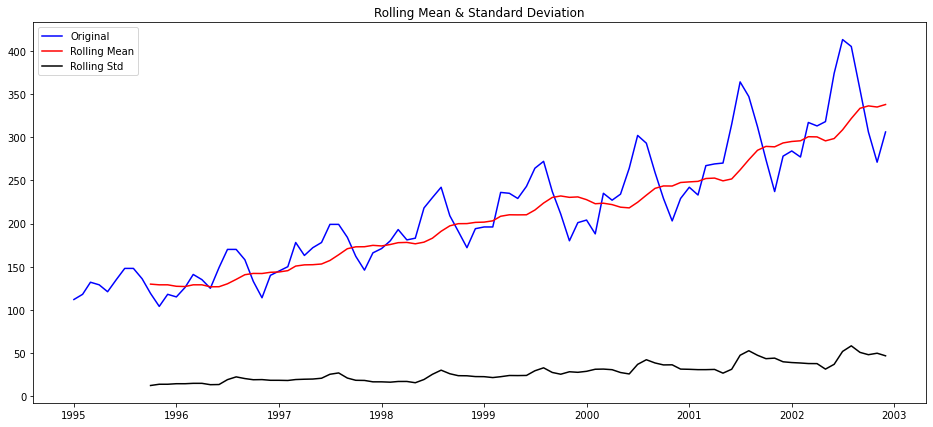

In [15]:
plt.figure(figsize=(16,7))
fig = plt.figure(1)
orig = plt.plot(airlines_data, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#### Method 2 - Augmented Dickey Fuller test 

In [16]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())                                            # to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

## 6. Making series Stationary

### 1. By transformation

In [17]:
plt.figure(figsize=(16,7))
fig = plt.figure(1)
plt.show()

<Figure size 1152x504 with 0 Axes>

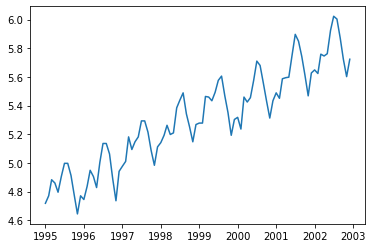

In [18]:
ts_log = np.log(airlines_data)           # to transform from non-stationary to stationary 
plt.plot(ts_log)

**Observation :-** 
- Even after log transformation, it is not becoming stationary. So we try to decompose into seasonal component by Decomposition.

### 2. Decomposition

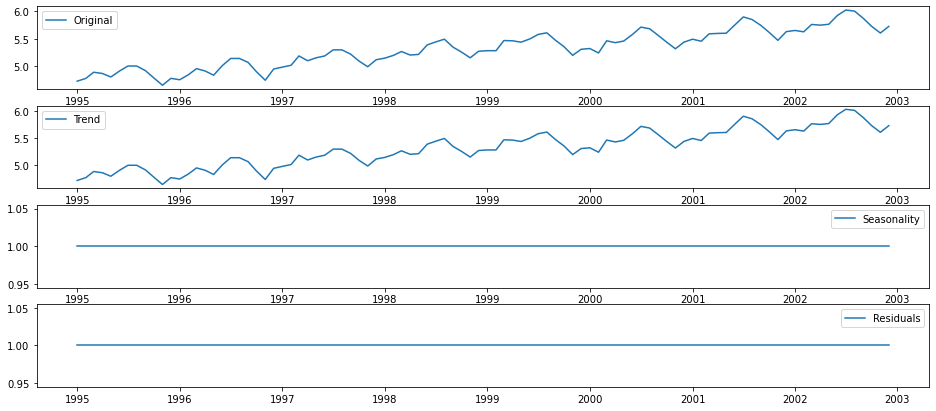

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,freq=1,model = 'multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,7))
fig = plt.figure(1)

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

- Trend component is contributing more to the time series.
- We have tried log transformation, but time-series is not becoming stationary. So we try to create a differenced time-series.
- Differencing => shifts the time series by 1 and subtracts from the original time-series to get stationarity. 

### 3. Differencing

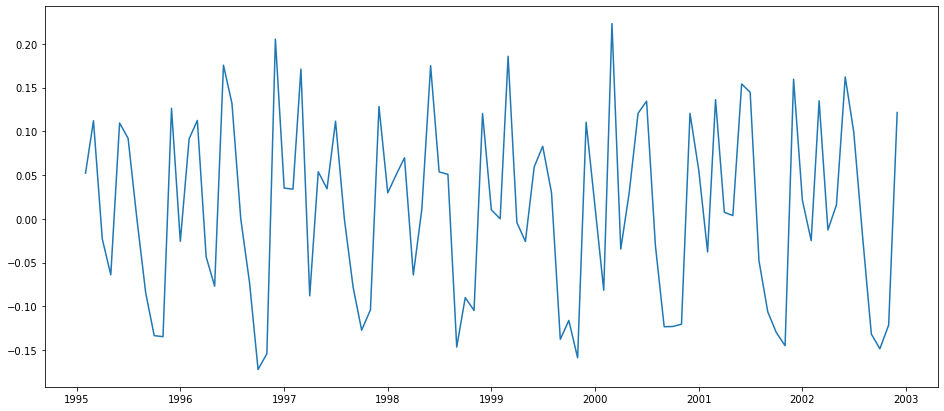

In [20]:
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ts_log_diff = ts_log - ts_log.shift()         # Time series is shifted by 1 and subtract from the original TS.
plt.plot(ts_log_diff)

##### Determining rolling statistics after Transformation, Decomposition and Differencing

In [21]:
rolLmean = ts_log_diff.rolling(12).mean()
rolLstd = ts_log_diff.rolling(12).std()

##### Plot rolling statistics after Transformation, Decomposition and Differencing

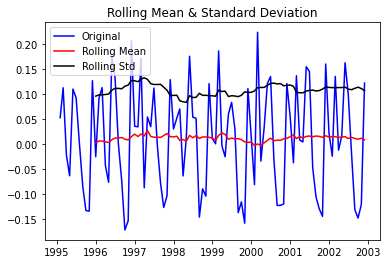

In [22]:
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

**Observation:-**
- After differncing, there is no pattern in the mean.
- No upward trend.
- No standard. 

In [23]:
airlines_data.sort_index(inplace= True)

**To know the order of AR and MA component and also to know what order suits better for our model, we perform ACF and PACF.**

In [24]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20)

## 7. Autocorrelation

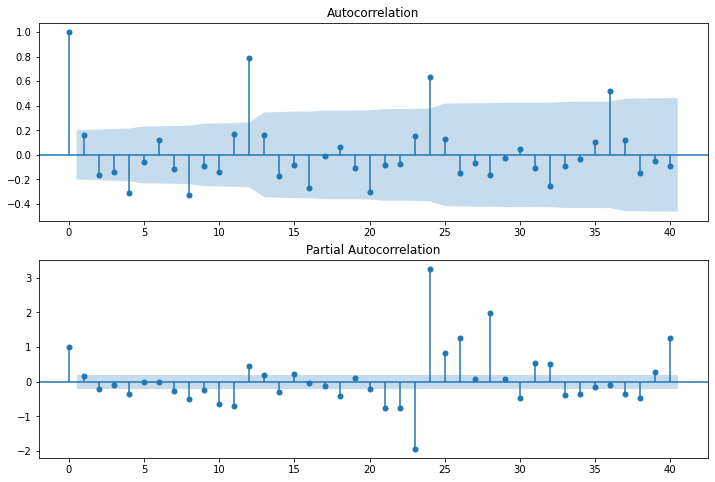

In [25]:
import statsmodels.api as smf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = smf.graphics.tsa.plot_acf(ts_log_diff.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = smf.graphics.tsa.plot_pacf(ts_log_diff.dropna(),lags=40,ax=ax2)

*Blue shaded line => CI. The 1st line crosses this blue line, is the order we want.*

## 8. Build ARIMA Model

In [26]:
from statsmodels.tsa.arima_model import ARIMA

In [27]:
type(ts_log_diff)

pandas.core.series.Series

In [28]:
#ts_log_diff.dropna()
ts_log_diff = ts_log_diff[~ts_log_diff.isnull()]

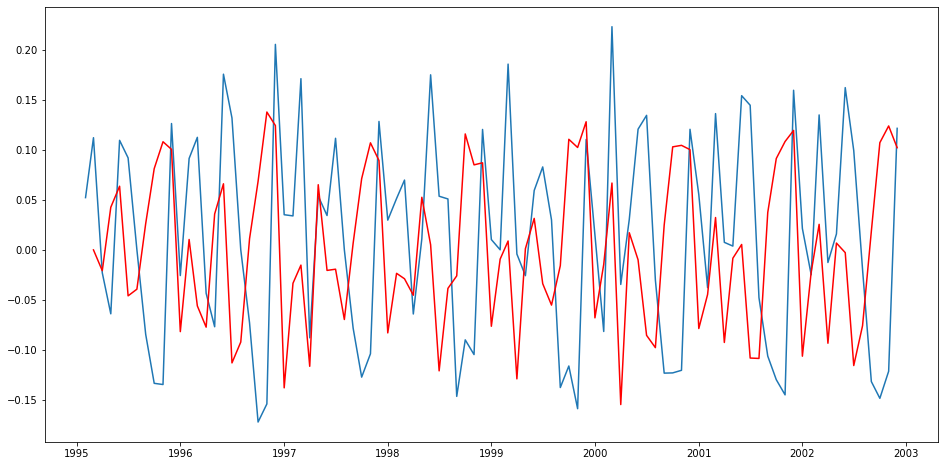

In [29]:
plt.figure(figsize=(16,8))
ts_log_diff.dropna(inplace=True)
model = ARIMA(ts_log_diff, order=(0,1,2))  
results_ARIMA = model.fit()  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

*Red line - actual line is scaled and differenced*

## 9. Taking results back to original scale

In [30]:
ARIMA_diff_predictions = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(ARIMA_diff_predictions.head())

Month
1995-03-01   -0.000097
1995-04-01   -0.020888
1995-05-01    0.042539
1995-06-01    0.063588
1995-07-01   -0.046048
dtype: float64


In [31]:
ARIMA_diff_predictions_cumsum = ARIMA_diff_predictions.cumsum()  # cumsum - Because of the difference of time series.
print(ARIMA_diff_predictions_cumsum.head()) 

Month
1995-03-01   -0.000097
1995-04-01   -0.020986
1995-05-01    0.021553
1995-06-01    0.085142
1995-07-01    0.039093
dtype: float64


In [32]:
ARIMA_log_prediction = pd.Series(ts_log.iloc[0], index=ts_log.index)       # addition - to compensate for the differencing done.
ARIMA_log_prediction = ARIMA_log_prediction.add(ARIMA_diff_predictions_cumsum,fill_value=0)
ARIMA_log_prediction.head()

Month
1995-01-01    4.718499
1995-02-01    4.718499
1995-03-01    4.718402
1995-04-01    4.697513
1995-05-01    4.740052
dtype: float64

Text(0.5, 1.0, 'RMSE: 116.9460')

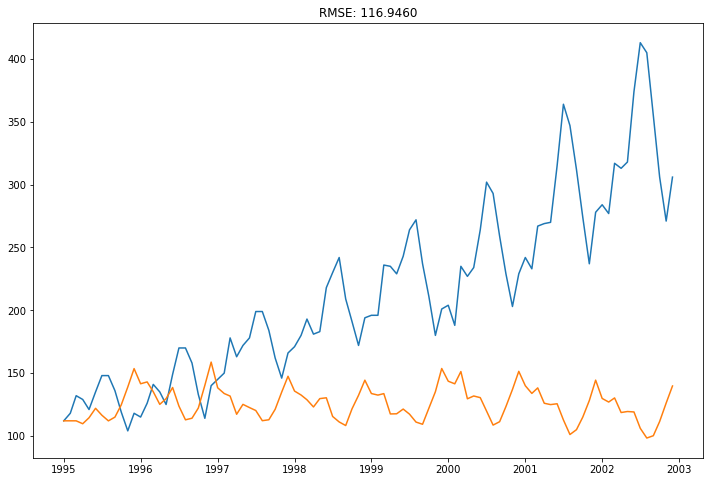

In [33]:
plt.figure(figsize=(12,8))
predictions_ARIMA = np.exp(ARIMA_log_prediction)                        # exp - opposite of log.
plt.plot(airlines_data)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-airlines_data)**2)/len(airlines_data)))

- Blue line is the actual value and orange line is the predicted values.

**Observations:-** 
- The predicted value can't capture the complte properties of actual fluctuations. Because we have choosen some random p, d and q.

In [34]:
results_ARIMA.predict(10,20)      # Predicting

1995-12-01    0.100430
1996-01-01   -0.081837
1996-02-01    0.010332
1996-03-01   -0.056119
1996-04-01   -0.077362
1996-05-01    0.035821
1996-06-01    0.066023
1996-07-01   -0.113106
1996-08-01   -0.092255
1996-09-01    0.011200
1996-10-01    0.068470
Freq: MS, dtype: float64

In [35]:
import pmdarima as pm
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=3, 
                              start_q=3,
                              max_p=5,
                              max_q=5,
                              test="adf",
                              seasonal=True,
                              trace=True)
    return automodel

In [36]:
arimamodel(ts_log)

Performing stepwise search to minimize aic
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-157.930, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=65.649, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-155.158, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-37.760, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=595.352, Time=0.00 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-155.271, Time=0.16 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-160.696, Time=0.28 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-157.140, Time=0.23 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-157.143, Time=0.20 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-164.774, Time=0.33 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-155.321, Time=0.23 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=-171.824, Time=0.30 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-160.398, Time=0.27 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=-158.111, Time=0.40 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   :

ARIMA(order=(5, 0, 2), scoring_args={}, suppress_warnings=True)

***Conclusion:-***
- Lower AIC scores are better and AIC penalizes models that use more parameters.
- Due to lower AIC score it will be the better-fit model.

**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**